In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.polynomial import Polynomial, polynomial
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import lagrange
from scipy.linalg import solve
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.signal import convolve
from scipy.optimize import curve_fit
from pathlib import Path
from scipy.interpolate import make_splrep
import pickle
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "CM Roman"
})

### Griglie, elementi finiti, calcolo M e A, avanzamento temporale

In [2]:
class GRID:
    def __init__(self, a, b, NumEl, scaling="lin",ndof=1,getM=False,NgridM=100,fe=None):
        if a>b:
            a, b = b, a 
        self.NumEl = NumEl 
        self.ndof = ndof
        self.DegOfFreedom = ndof*NumEl-1
        if scaling=="lin":
            self.V = np.linspace(a, b, NumEl+1)
        elif scaling=="log":
            self.V = np.logspace(a, b, NumEl+1)
        self.ElemSize = np.diff(self.V) #lunghezza degli intervalli
        self.MidPoints = (self.V[:-1]+self.V[1:])/2 #punti medi
        # mette nodi equispaziati per elementi di grado > 1
        self.globV = self.V
        for i in range(1,ndof):
            self.globV = np.r_[self.globV,self.V[:-1]+self.ElemSize*i/ndof]
        self.globV = np.sort(self.globV)

        # precalcola la matrice di massa
        if getM:
            p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
            grigliaref = GRID(0,1,NgridM) #la griglia per l'integrazione sull'elemento di riferimento
            gaussdeg = max(int(ndof/2),1) #da rivedere - precisione quadratura
            self.Mlocal = np.zeros((ndof+1,ndof+1))
            for k in range(ndof+1):
                for j in range(ndof+1):
                    self.Mlocal[k,j] = grigliaref.integrate(lambda x: p[k](x)*p[j](x),deg=gaussdeg)
            self.M = np.zeros((self.DegOfFreedom,self.DegOfFreedom))
            LTG = LTGdd(ndof,NumEl) #già decise condizioni di Dirichlet omogenee
            for l in range(NumEl):
                for k in range(ndof+1):
                    row = LTG[l,k]
                    if row<0:
                        continue
                    for j in range(ndof+1):
                        col = LTG[l,j]
                        if col<0:
                            continue
                        self.M[row,col] += self.Mlocal[k,j]
            self.M *= self.ElemSize[l] #l'esponente giusto dovrebbe essere 1
            
    def integrate(self,f,deg=1):
        return sum([quad(f,deg,a=self.V[i],b=self.V[i+1]) for i in range(self.NumEl)])

class FE:
    def __init__(self, ndof):
        self.ndof = ndof
        # nodi locali
        self.Xref = np.linspace(0,1,ndof+1)
        points = 0*self.Xref
        self.Pol = [None]*(ndof+1)
        # definisce i polinomi di Lagrange sui nodi associati
        for i in range(ndof+1):
            points[i] = 1 # il polinomio i-esimo deve valere 1 al nodo i-esimo
            pol = lagrange(self.Xref, points)
            self.Pol[i] = Polynomial(pol.coef[::-1])
            points[i] = 0 # spengo il nodo
        # calcolo derivate
        self.PolDer = [p.deriv() for p in self.Pol]

def getA(fe,griglia,a,constantdiffusion=False,NgridA=10):
    #calcola la matrice di rigidezza, a seconda se ci sono diffusione/trasporto non costanti spazialmente
    p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof

    gaussdeg = max(int(ndof/2),1) #da rivedere - precisione quadratura
    gaussdeg = 3
    NumEl, xL, dx = griglia.NumEl, griglia.V[:-1], griglia.ElemSize
    LTG = LTGdd(ndof,NumEl)
    A = np.zeros((griglia.DegOfFreedom,griglia.DegOfFreedom))
    grigliaref = GRID(0,1,NgridA)
    #questo assumene che a(u,v,[du,du]) non dipende da x
    if constantdiffusion:
        Alocal = np.zeros((ndof+1,ndof+1))
        for k in range(ndof+1):
            for j in range(ndof+1):
                Alocal[k,j] = grigliaref.integrate(lambda x: a(p[j],p[k],dp[j],dp[k])(x),deg=gaussdeg)
        for l in range(NumEl):
            for k in range(ndof+1):
                row = LTG[l,k]
                if row<0:
                    continue
                for j in range(ndof+1):
                    col = LTG[l,j]
                    if col<0:
                        continue
                    A[row,col] += Alocal[k,j]
    else:
        for l in tqdm(range(NumEl)):
            for k in range(ndof+1):
                row = LTG[l,k]
                if row<0:
                    continue
                for j in range(ndof+1):
                    col = LTG[l,j]
                    if col<0:
                        continue
                    A[row,col] += grigliaref.integrate(lambda x: a(p[j],p[k],dp[j],dp[k],xL[l],dx[l])(x),deg=gaussdeg)
    # A /= dx[l]
    return A

def advance(u,dt,M,A):
    #calcola u+1 con crank-nickolson
    K = M + dt*A/2
    g = np.dot((M - dt*A/2),u[1:-1])
    # metodi per matrici sparse
    K, g = csc_matrix(K,dtype=float), csc_matrix(g,dtype=float).T
    unew_inner = spsolve(K,g)
    unew = np.r_[u[0],unew_inner,u[-1]]
    return unew

### Utilità varie

In [3]:
def quad(f,deg,a=0,b=1):
    # quadratura gaussiana
    x, w = leggauss(deg)
    x = (x+1)/2
    w /= 2
    h = (b-a)
    X = a + h*x
    I = sum(w*f(X))*h
    return I

def LTGdd(ndof,NumEl):
    #matrice local to global per condizioni al contorno di dirichlet
    N = ndof*NumEl-1
    right = np.r_[np.arange(N),-1].reshape((-1,ndof))
    left = np.r_[-1,right[:-1,-1]].reshape((-1,1))
    return np.c_[left,right]

def line(x,m,q):
    return m*x+q

def fix_lims(ax,condition):
    global xlim0, ylim0
    if condition:
        xlim0 = ax.get_xlim()
        ylim0 = ax.get_ylim()
    else:
        ax.set_xlim(xlim0)
        ax.set_ylim(ylim0)

### Condizioni iniziali utili

In [4]:
def waterbag(x,mu,sigma):
    return (x>mu-eps)*(x<mu+eps)
    
def gauss(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/sigma**2)

def sph(q):
    # tipico kernel sph, da usare come distribuzione iniziale C^2 a supporto [-2h,2h]
    w = q*0
    c1 = (0<=q) & (q<=1/2)
    c2 = (1/2<=q) & (q<=1)
    w[c1] = 1-6*q[c1]**2+6*q[c1]**3
    w[c2] = 2*(1-q[c2])**3
    return w

def nicekernel(x,mu,h):
    return sph(np.abs(x-mu)/(2*h))

## Dischi di accrescimento

### Funzione di Green per l'equazione dei dischi, implementazione numericamente stabile
In variabili "standard", la soluzione dell'equazione per condizione iniziale
$$\Sigma(r,t=0) = \frac{M_0}{2\pi R_0}\delta(r-R_0)$$
per $\alpha<2$ è data da
$$\Sigma(r,t) = 
\frac{M_0(1-\alpha/2)}{\pi R_0^2 \xi^{(\alpha+1/4)} \tau}
\exp{-\frac{1+\xi^{2-\alpha}}{\tau}}
I_{1/|4-2\alpha|}\left(\frac{2\xi^{1-\alpha/2}}{\tau}\right)$$

dove 
- $M_0$ è la massa iniziale del disco
- $\xi=r/R_0$
- $\tau = t[12 A (1-\alpha/2)^2/R_0^2]$ tempo caratteristico della diffusione
ma noi ora usiamo $A=1/3$ quindi 
$$\tau = \left(\frac{2-\alpha}{R_0}\right)^2 t$$
e quindi il prefattore si semplifica a 
$$\frac{M_0}{2\pi(2-\alpha)\xi^{\alpha+1/4}t}$$
- $I_m(z)$ è la funzione di Bessel modificata di ordine $m$

La soluzione va poi convertita per la nostra variabile $u=2\pi r \Sigma$ (praticamente la massa $M$).

### Problemi di overflow/underflow

Nella formula sopra, per argomenti grandi, l'esponenziale assume valori estremamente piccoli, la Bessel estremamente grandi.

Le funzioni di Bessel modificate ammettono la forma asintotica

$$I_{m}(z) \approx \frac{1}{\sqrt{2\pi z}\sqrt[4]{1+b^2}} \exp\left(-m\text{ arcsinh } b + z\sqrt{1+b^2}\right)$$

dove $b=m/z$, che per $m=1/2$ oppure prendendo la formula sopra per $b\ll 1$ diventa

$$I_{m}(z) \approx \frac{\exp z}{\sqrt{2\pi z}}$$

*indipendentemente da $m$*. Questa può sembrare un'approssimazione forte ma per $z\gtrsim 10$ il risultato è praticamente indistinguibile.

In questo modo nella funzione di Green il prodotto dell'esponenziale e della Bessel si semplifica (trascurando il denominatore dell'ultima formula) a 

$$\exp{\frac{(\xi^{1-\alpha/2}-1)^2}{\tau}} = \exp{R_0^{\alpha-2}\frac{(r^{1-\alpha/2}-R_0^{1-\alpha/2})^2}{\tau}}$$

che è la tipica forma di "gaussiana" di centro $R_0$ e larghezza $\sqrt{\tau}$ (per $\alpha\neq 0$ ovviamente non è proprio una gaussiana).

Praticamente con il senno di poi nella formula originale l'esponenziale conteneva la somma dei quadrati, mentre la funzione di Bessel il doppio prodotto.

Usando questa approssimazione quando l'argomento della Bessel supera una certa soglia, i problemi di overflow/underflow spariscono.

In [5]:
from scipy.special import iv, gamma
def disckernel(r,R0,t,alpha=0,approx=True):
    #implementazione numericamente stabile che usa
    #forma asintotica semplificata per le funzioni di bessel modificate
    thresh = 10 #valore minimo di z per usare l'espressione di I(z>>1)
    xi = r/R0
    # i calcoli sono già fatti nel raggio adimensionale x
    tauu = t*(2-alpha)**2/R0**(2-alpha) # tempo caratteristico della diffusione
    amplitude = (1-alpha/2)/(np.pi*R0**2*xi**(alpha+1/4)*tauu)
    z = 2*xi**(1-alpha/2)/tauu # argomento della bessel
    besselorder = 1/np.abs(4-2*alpha)
    big = z*0 # inizializzo il termine problematico, prodotto exp*bessel
    if xi.size>1: # argomento vettoriale
        if approx:
            approx = z>=thresh
            noapprox = z<thresh
        else:
            approx = [False]*len(z)
            noapprox = [True]*len(z)
        if np.any(approx):
            big[approx] = np.exp(-(xi[approx]**(1-alpha/2)-1)**2/tauu[approx])/(np.sqrt(2*np.pi*z[approx]))
        if np.any(noapprox):
            # per z sotto la soglia utilizzo la formula esatta
            exponential = np.exp(-(1+xi[noapprox]**(2-alpha))/tauu[noapprox])
            bessel = iv(besselorder,z[noapprox])
            big[noapprox] = exponential*bessel
    else: #argomento scalare
        if approx:
            if z>=thresh:
                big = np.exp(-(xi**(1-alpha/2)-1)**2/tauu)/(np.sqrt(2*np.pi*z))
        else:
            exponential =  np.exp(-(1+xi**(2-alpha))/tauu)
            bessel = iv(besselorder,z)
            big = exponential*bessel
    Sigma = amplitude*big
    # converto da densità a massa
    M = 2*np.pi*r*Sigma
    return M

def iv_asymptotic(m,z):
    # formula asintotica per z grande
    b = m/z
    amplitude = 1/(np.sqrt(2*np.pi*z)*(1+b**2)**(1/4))
    exponential = np.exp(-m*np.arcsinh(b)+z*np.sqrt(1+b**2))
    return amplitude*exponential

def iv_stupid(z):
    # formula estremamente approssimata che è quella che vado ad usare poi
    # praticamente iv_asymptotic per a (ordine della Bessel) piccolo
    # la formula è esattamente iv_asymptotic per a=1/2
    amplitude = 1/(np.sqrt(2*np.pi*z))
    exponential = np.exp(z)
    return amplitude*exponential

def discexact(r,t,u0,grigliaconv,alpha=0,approx=True):
    # soluzione esatta disco, integrazione gaussiana
    if t==0:    
        return u0(r) #dà comunque problemi, meglio non usare
    else:
        y = r*0
        for i in range(len(r)):
            rvar = r[i]
            y[i] = grigliaconv.integrate(lambda R0: disckernel(rvar,R0,t,alpha=alpha,approx=approx)*u0(R0),deg=3)
        return y


# Equazione dei dischi

### Forma quadratica

In [6]:
def adisc(u,v,du,dv,xL=0,dx=1):
    #v in realtà non viene usata ma almeno c'è chiarezza
    mu = lambda r: r**alpha
    # b = lambda x: C
    b = lambda r: -(alpha-1/2)*r**(alpha-1)
    xrest = lambda r: xL+r*dx # dà x vero in funzione di x di riferimento
    return lambda r: (mu(xrest(r))*du(r)/dx-b(xrest(r))*u(r))*dv(r)

### Analisi scan spaziale

100%|██████████| 5/5 [00:00<00:00, 5405.03it/s]


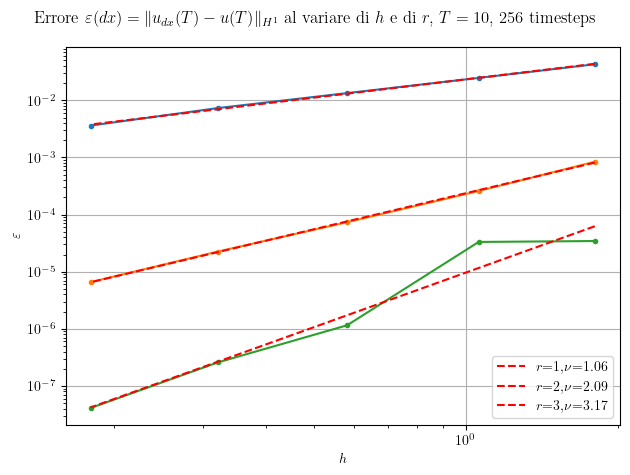

In [53]:
figfolder = f"graphics/scan/dt9spaziale0"
Path(figfolder).mkdir(parents=True,exist_ok=True)
picklefile = f"{figfolder}/curve.pkl"

with open(picklefile,"rb") as f:
    readout = pickle.load(f)

ndofs = [res["ndof"] for res in readout]
alpha = readout[0]["alpha"]
T = readout[0]["T"]
a, b = 10, 100
Ns = np.logspace(1,2,10).astype(int)
hs = (b-a)/Ns
eps = (b-a)/50
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

include_err0 = 1
include_err1 = 1

errs_ndofs = []
for i in range(len(readout)):
    errs = []
    us = readout[i]["us"]
    Ys = readout[i]["Ys"]
    dus = readout[i]["dus"]
    dYs = readout[i]["dYs"]
    for j in tqdm(range(len(us))):
        u = us[j]
        X = np.linspace(a,b,len(us))
        Y = Ys[j]
        du = dus[j]
        dY = dYs[j]
        err = np.sqrt(np.sum(include_err0*(u-Y)**2+include_err1*(du-dY)**2))
        errs.append(err)
    errs = np.array(errs)
    readout[i]["errs"] = errs 
errfile = f"{figfolder}/err.pkl"

with open(errfile,"wb") as f:
    pickle.dump(readout,f)

fig, ax = plt.subplots()

for i in range(len(readout)):
    errs = readout[i]["errs"]
    hs = readout[i]["hs"][:len(errs)]
    errs = errs*np.sqrt(hs)
    Xfit = np.log10(hs)
    Yfit = np.log10(errs)
    popt, _ = curve_fit(line,Xfit,Yfit)
    ax.plot(hs,errs,'.-')
    ax.plot(hs,10**line(Xfit,*popt),'--r',label=f"$r$={readout[i]["ndof"]},$\\nu$={popt[0]:0.2f}")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\varepsilon$")
ax.grid()
fig.suptitle("Errore $\\varepsilon(dx) = \\|{u_{dx}(T)-u(T)}\\|_{H^1}$ al variare di $h$ e di $r$, $T=10$, 256 timesteps")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("graphics/spaziale-bootstrap-dt9.png")

100%|██████████| 11/11 [00:00<00:00, 7147.54it/s]


100%|██████████| 11/11 [00:00<00:00, 5356.09it/s]


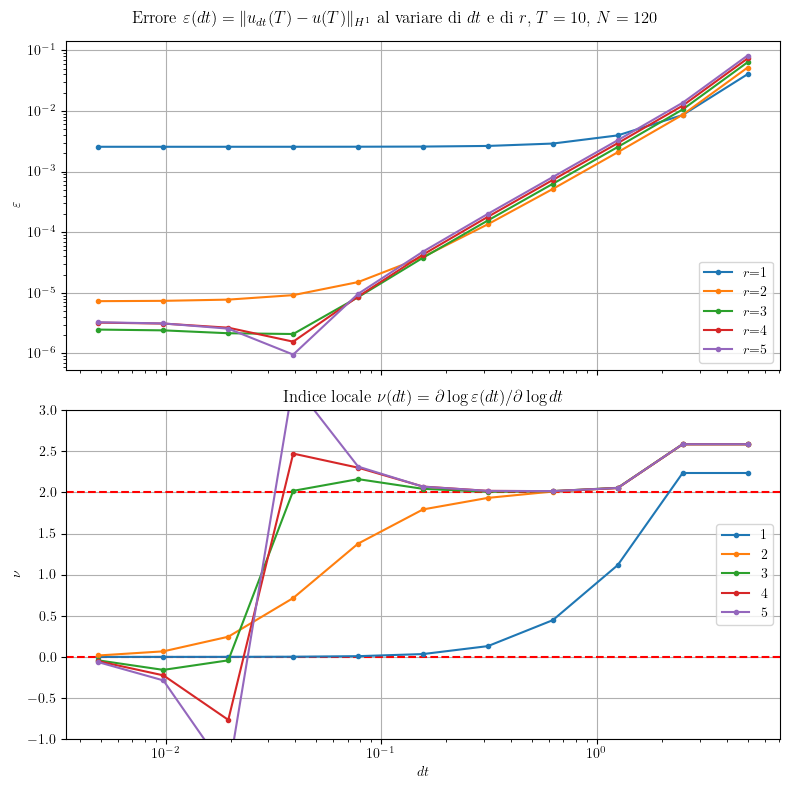

In [52]:
figfolder = f"graphics/scan/dx1temporale0"
Path(figfolder).mkdir(parents=True,exist_ok=True)
picklefile = f"{figfolder}/curve.pkl"

with open(picklefile,"rb") as f:
    readout = pickle.load(f)

ndofs = [res["ndof"] for res in readout]
alpha = readout[0]["alpha"]
T = readout[0]["T"]
a, b = 10, 100
N = 120
h = (b-a)/N
eps = (b-a)/50
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

include_err0 = 1
include_err1 = 0

errs_ndofs = []
for i in range(len(readout)):
    errs = []
    us = readout[i]["us"]
    Ys = readout[i]["Ys"]
    dus = readout[i]["dus"]
    dYs = readout[i]["dYs"]
    for j in tqdm(range(len(us))):
        u = us[j]
        X = np.linspace(a,b,len(us))
        Y = Ys[j]
        du = dus[j]
        dY = dYs[j]
        err = np.sqrt(h*np.sum(include_err0*(u-Y)**2+include_err1*(du-dY)**2))
        errs.append(err)
    errs = np.array(errs)
    readout[i]["errs"] = errs 
errfile = f"{figfolder}/err.pkl"

with open(errfile,"wb") as f:
    pickle.dump(readout,f)

fig, (ax, axd) = plt.subplots(2,sharex=True,figsize=(8,8))
axd.axhline(2,ls="--",color="r")
axd.axhline(0,ls="--",color="r")
def powerlaw_baseline(x,nu,A,base):
    return A*x**nu + base
def powerlaw(x,nu,A):
    return A*x**nu

for i in range(len(readout)):
    if i==1 or True:
        errs = readout[i]["errs"]
        dts = T/2**np.arange(1,12)[:len(errs)]
        Xspl = np.log10(dts)[::-1]
        Yspl = np.log10(errs)[::-1]
        spl = make_splrep(Xspl,Yspl,k=1,s=0)
        dspl = spl.derivative(1)
        axd.plot(10**Xspl,dspl(Xspl),'.-',label=f"{readout[i]["ndof"]}")

        axd.set_ylim(-1,3)
        # popt, _ = curve_fit(powerlaw,dts[:4],errs[:4]-errs[-1])
        # popt, _ = curve_fit(powerlaw_baseline,dts,errs,p0=[2,1e-3,1e-5])
        ax.plot(dts,errs,'.-',label=f"$r$={readout[i]["ndof"]}")
        # ax.plot(10**Xfit,10**Yfit)
        # ax.plot(10**Xfit,10**line(Xfit,*popt),'--r',label=f"Ndof={readout[i]["ndof"]},m={popt[0]:0.2f}")
        # ax.plot(dts,powerlaw(dts,*popt)+errs[-1],'--r',label=f"Ndof={readout[i]["ndof"]},m={popt[0]:0.2f}")
fig.suptitle("Errore $\\varepsilon(dt) = \\|{u_{dt}(T)-u(T)}\\|_{H^1}$ al variare di $dt$ e di $r$, $T=10$, $N=120$")
ax.set_xscale("log")
ax.set_yscale("log")
axd.set_xscale("log")
axd.set_xlabel("$dt$")
axd.set_ylabel("$\\nu$")
ax.set_ylabel("$\\varepsilon$")
axd.set_title("Indice locale $\\nu(dt) = \\partial\\log \\varepsilon(dt)/\\partial\\log dt$")
axd.grid()
ax.grid()
ax.legend()
axd.legend()
plt.tight_layout()
plt.show()
fig.savefig("graphics/temporale-bootstrap-dx1.png")